In [75]:
import sys
sys.path.append("..")

import os
import os.path as osp
import random

In [76]:
import os
import numpy as np

total_samples = 0
total_labels = set()

PARTNO_ROOT = "../data/partanno"

for cls_dir in os.listdir(PARTNO_ROOT):
	if not osp.isdir(osp.join(PARTNO_ROOT, cls_dir)):
		continue
	if not osp.exists(osp.join(PARTNO_ROOT, cls_dir, "points")) or \
		not osp.exists(osp.join(PARTNO_ROOT, cls_dir, "points_label")):
		continue
	total_samples += len(os.listdir(osp.join(PARTNO_ROOT, cls_dir, "points")))

	for label_txt in os.listdir(osp.join(PARTNO_ROOT, cls_dir, "points_label")):
		label_txt = osp.join(PARTNO_ROOT, cls_dir, "points_label", label_txt)
		total_labels.update(np.unique(np.loadtxt(label_txt).astype(np.int32)))


print(total_samples, total_labels)

17775 {1, 2, 3, 4, 5, 6}


In [77]:
def ply_render(
	pcd,
	img_h: int, img_w: int,
	eye: list, up: list,
	output_path: str
):
	'''
	'''
	import numpy as np
	import open3d as o3d
	import open3d.visualization.rendering as rendering
	renderer = rendering.OffscreenRenderer(img_h, img_w)
	# 设置背景颜色 (RGBA)
	renderer.scene.set_background([0.1, 0.1, 0.1, 1.0])

	# 创建材质
	mtl = rendering.MaterialRecord()
	mtl.base_color = [1.0, 1.0, 1.0, 1.0]  # 白色
	mtl.shader = "defaultUnlit"
	# 设置点的大小 (以像素为单位)
	# Open3D 0.19.0 及更新版本可能支持通过材质参数调整点大小
	# 对于较旧版本，可能需要查找渲染器或场景的其他属性
	mtl.point_size = 5  # 例如，将点大小设置为 5 像素
	# 将材质应用于点云
	renderer.scene.add_geometry("point_cloud", pcd, mtl)
	
	vfov = 45.0 # 垂直视场角
	aspect_ratio = img_w / img_h
	near_plane = 0.1
	far_plane = 100.0
	fov_type = rendering.Camera.FovType.Vertical
	renderer.scene.camera.set_projection(vfov, aspect_ratio, near_plane, far_plane, fov_type)
	renderer.scene.camera.look_at([0, 0, 0], eye, up)

	# 进行离屏渲染
	image_o3d = renderer.render_to_image()
	# 保存图片
	o3d.io.write_image(output_path, image_o3d)

In [78]:
import open3d as o3d
import numpy as np

PARTNO_ROOT = "../data/partanno"

syn2cls = dict()
with open(osp.join(PARTNO_ROOT, "synsetoffset2category.txt"), "r") as f:
    lines = f.readlines()
    for line in lines:
        category, synset_offset = line.strip().split()
        syn2cls[synset_offset] = category
synset_list = list(syn2cls.keys())

In [100]:
# 使用 np 从 synset_list 种随机挑选一个
synset = np.random.choice(synset_list, 1)[0]
print(synset)
sample_list = os.listdir(osp.join(PARTNO_ROOT, synset, "points"))

sample = osp.splitext(np.random.choice(sample_list, 1)[0])[0]
print(sample)

points = np.loadtxt(osp.join(PARTNO_ROOT, synset, "points", f"{sample}.pts"), delimiter=" ")
labels = np.loadtxt(osp.join(PARTNO_ROOT, synset, "points_label", f"{sample}.seg"), delimiter=" ").astype(np.int32)

03624134
bcd7ed830358dbd6d58ea69ee1ced10e


In [101]:
# # 根据 labels 中出现过的标签，生成一个调色盘 pallete
# pallete = np.random.rand(len(np.unique(labels)), 3)
# pallete = pallete / np.sum(pallete, axis=1, keepdims=True)
# # pallete = (pallete * 255).astype(np.uint8)
# print(pallete)

# # 使用 open3d 可视化 points 和 labels
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points)
# pcd.colors = o3d.utility.Vector3dVector(pallete[labels - 1])

# ply_render(pcd, 512, 512, [1, 1, 1], [0, 1, 0], "test.png")

In [102]:
import numpy as np
def snapshot_voxel(
	coords: np.ndarray, labels: np.ndarray,
	voxel_size: float, resolution: list, 
	cam_pos, eye_pos
):
	'''
	Params
	-
	* coords: np.ndarray, (N, 3), not point features, but point coordinates
	* labels: np.ndarray, (N, )
	* voxel_size: float
	* resolution: list, tuple - (H, W)
	* cam_pos: np.ndarray, list, tuple - initial camera position
	* eye_pos: np.ndarray, list, tuple	- where camera towards
	Return
	-
	* feat_map: np.ndarray, (H, W) - feature map with each pixel labeled class index
	'''
	if not isinstance(coords, np.ndarray):
		raise TypeError("coords must be np.ndarray")
	if not isinstance(labels, np.ndarray):
		raise TypeError("labels must be np.ndarray")
	if not isinstance(voxel_size, float):
		raise TypeError("voxel_size must be float")
	if not isinstance(resolution, np.ndarray):
		if isinstance(resolution, list) or isinstance(resolution, tuple):
			resolution = np.array(resolution, dtype=np.int32)
		else:
			raise TypeError("cam_pos must be np.ndarray/list/tuple")
	if not isinstance(cam_pos, np.ndarray):
		if isinstance(cam_pos, list) or isinstance(cam_pos, tuple):
			cam_pos = np.array(cam_pos, dtype=np.float32)
		else:
			raise TypeError("cam_pos must be np.ndarray/list/tuple")
	if not isinstance(eye_pos, np.ndarray):
		if isinstance(eye_pos, list) or isinstance(eye_pos, tuple):
			eye_pos = np.array(eye_pos, dtype=np.float32)
		else:
			raise TypeError("eye_pos must be np.ndarray/list/tuple")

	import utils
	# make a copy of the original points
	coords = coords.copy()
	orgidx = np.arange(len(coords))

	# 移动视点至投影中心
	coords -= eye_pos
	cam_pos -= eye_pos
	cam_pos /= np.linalg.norm(cam_pos)


	# cam_pos 现在就是投影轴，设 cam_pos 为 z 轴，投影平面为 x-y 平面，将 cam_pos 变换至 [0,0,1] z 轴
	R = utils.A2B_R(cam_pos, np.array([0,0,1]))
	# 与 X-Y 平面轴对齐
	coords = coords @ R.T
	
	# 根据 range 限定的范围，裁剪点云（给定以 cam_pos 为中心的长宽，单位为米，只裁剪 X-Y 平面，Z 轴无限制）
	coords_vxlzed = (coords // voxel_size).astype(np.int32)
	# 保留拍摄栅格范围内的体素
	mask  = np.abs(coords_vxlzed[:, 0]) < (resolution[0] // 2)
	mask &= np.abs(coords_vxlzed[:, 1]) < (resolution[1] // 2)

	coords_vxlzed_clipped = coords_vxlzed[mask]
	labels_clipped = labels[mask]
	orgidx_clipped = orgidx[mask]

	# 转换为屏幕栅格坐标系
	coords_vxlzed_clipped = coords_vxlzed_clipped - coords_vxlzed_clipped.min(axis=0)
	
	# voxels = np.zeros((*(coords_vxlzed.max(axis=0) + 1), labels.max() + 1), dtype=np.int32)
	voxels = np.zeros((
		resolution[0],
		resolution[1],
		coords_vxlzed_clipped.max(axis=0)[2] + 1,
		labels.max() + 1
	), dtype=np.int32)
	np.add.at(voxels, (*coords_vxlzed_clipped.T, labels_clipped), 1)

	# 每个体素的类别取类别计数最高的那个类别
	voxels = voxels.argmax(axis=-1)

	# 1. 提取非空体素坐标 nz_idxs = non_zero_indices
	nz_idxs = np.nonzero(voxels)
	# 以 Z 轴投影方向平面上体素横纵坐标
	nz_idxs_xy_tuple = np.array(list(zip(nz_idxs[0], nz_idxs[1])), dtype=[('x', 'int'), ('y', 'int')])
	
	# 2. 提取非空体素坐标中的第一个非重复坐标
	_, nz_nz_idxs = np.unique(nz_idxs_xy_tuple, return_index=True)

	data = np.zeros(voxels.shape[:2], dtype=np.int32)
	gdth = np.zeros(voxels.shape[:2], dtype=np.int32)

	# 构造深度图，Z 轴索引等价于深度
	data[nz_idxs[0][nz_nz_idxs], nz_idxs[1][nz_nz_idxs]] = nz_idxs[2][nz_nz_idxs]

	# 构造语义分割图
	gdth[
		nz_idxs[0][nz_nz_idxs],
		nz_idxs[1][nz_nz_idxs]
	] = voxels [
		nz_idxs[0][nz_nz_idxs],
		nz_idxs[1][nz_nz_idxs],
		nz_idxs[2][nz_nz_idxs]
	]

	# 构造原始点云索引索引到投影图像素的映射
	coords_vxlzed_clipped_xy_tuple = np.array(
		list(zip(coords_vxlzed_clipped[:, 0], coords_vxlzed_clipped[:, 1])),
		dtype=[('x', 'int'), ('y', 'int')]
	)
	# 这个掩码标记了那些在存在于非空体素中的点云的索引
	mask = np.isin(coords_vxlzed_clipped_xy_tuple, nz_idxs_xy_tuple[nz_nz_idxs])
	rmap = np.hstack([orgidx_clipped.reshape(-1, 1), coords_vxlzed_clipped[mask, :2]])

	return data, gdth, rmap

retain rate: 0.55


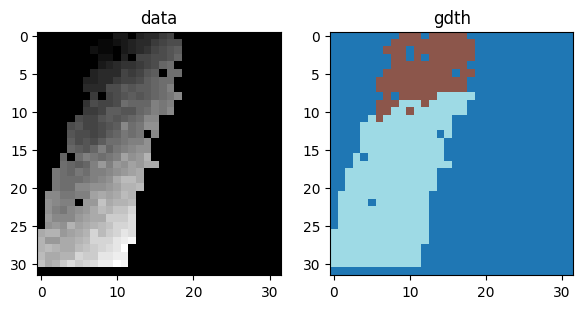

In [103]:
data, gdth, rmap = snapshot_voxel(points[:, :3], labels, 0.01, [32, 32], [-1, -1, -1], [0, 0, 0])
print(f"retain rate: {len(rmap) / len(points):.2f}")

import matplotlib.pyplot as plt
# 创建包含两个子图的图形
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
# 在第一个子图中显示 data
axs[0].imshow(data, interpolation='nearest', cmap='gray')
axs[0].set_title('data')
# 在第二个子图中显示 gdth
axs[1].imshow(gdth, interpolation='nearest', cmap='tab20')
axs[1].set_title('gdth')
# 调整布局
plt.tight_layout()
plt.show()

In [104]:
# 检查 rmap 的正确性
pallete = np.random.rand(labels.max() + 1, 3)
pallete = pallete / np.sum(pallete, axis=1, keepdims=True)

pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points[rmap[:, 0]])
# pcd.colors = o3d.utility.Vector3dVector(pallete[gdth[rmap[:, 1], rmap[:, 2]] - 1])
pcd.points = o3d.utility.Vector3dVector(points)
colors = np.ones((len(points), 3)) * 0.5
colors[rmap[:, 0]] = pallete[gdth[rmap[:, 1], rmap[:, 2]] - 1]
pcd.colors = o3d.utility.Vector3dVector(colors)
# 保存到 ply 文件
o3d.io.write_point_cloud("pcd.ply",  pcd)
ply_render(pcd, 512, 512, [1, 1, 1], [0, 1, 0], "test.png")

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x9525150 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


In [105]:
# 示例数组
arr = np.array([
    [0, 2, 0, 3],
    [0, 0, 0, 4],
    [0, 0, 5, 6]
])
# arr = np.array(object=[[0, 1, 0]])
# 获取非零元素的索引
non_zero_indices = np.nonzero(arr)
print(non_zero_indices)

# 使用 np.unique 获取唯一值和它们第一次出现的索引
unique_values, indices = np.unique(non_zero_indices[0], return_index=True)
print("=== fisrt none zero index ===")
print(indices)
print(non_zero_indices[1][indices])

a = non_zero_indices[0][indices]
b = non_zero_indices[1][indices]

print("=== first none zero hit ===")
print(arr[a, b])

(array([0, 0, 1, 2, 2]), array([1, 3, 3, 2, 3]))
=== fisrt none zero index ===
[0 2 3]
[1 3 2]
=== first none zero hit ===
[2 4 5]


In [106]:
import numpy as np

# 示例数组
arr = np.array([1, 2, 2, 3, 4, 4, 5, 1])

# 使用 np.unique 获取唯一值和它们第一次出现的索引
unique_values, indices = np.unique(arr, return_index=True)

# 打印结果
print("Unique values:", unique_values)
print("Indices of first occurrences:", indices)

Unique values: [1 2 3 4 5]
Indices of first occurrences: [0 1 3 4 6]
